# Demo 1 - Cats and Horses

## Part 1 – Transformers and Image Classification (7 points)

Here we want to compare how Transformers perform when compared to other kinds of networks for image classification, such as CNNs. Follow the tutorial [here](https://huggingface.co/docs/transformers/tasks/image_classification) in order to implement an image classification model.

The tutorial uses a model called ViT (Visual Transformer), which was the first transformer model to perform better at image classification than a CNN did.

In [ ]:
pip install transformers datasets evaluate

In [ ]:
pip install transformers[torch]

In [ ]:
#loads dataset and splits it into train and test set
from datasets import load_dataset
food = load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)

#look at example
print(food["train"][:2])

# creates a dictionary that maps the label name to an integer and vice versa
labels = food["train"].features["label"].names

label2id, id2label = dict(), dict()

for i, label in enumerate(labels):

    label2id[label] = str(i)

    id2label[str(i)] = label

#look at example
id2label[str(79)]

In [ ]:
#Preprocessing
from transformers import AutoImageProcessor
checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

#crops a random part of the image, resizes it, and normalizes it with the image mean and standard deviation
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (

    image_processor.size["shortest_edge"]

    if "shortest_edge" in image_processor.size

    else (image_processor.size["height"], image_processor.size["width"])

)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

#applies the transforms and returns the pixel_values - the inputs to the model - of the image
def transforms(examples):

    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]

    del examples["image"]

    return examples

food = food.with_transform(transforms)

#creates a batch of examples
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()


In [ ]:
#Evaluation

import evaluate

accuracy = evaluate.load("accuracy")

#passes your predictions and labels to compute to calculate the accuracy
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
pip install accelerate -U

In [ ]:
#Training 

#EITHER THIS CELL OR THE NEXT CELL, NOT BOTH

from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

#defines training hyperparameters
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

#passes training arguments and information about model etc. to the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

#finetune the model
trainer.train()


The fine-tuning with pytorch worked:
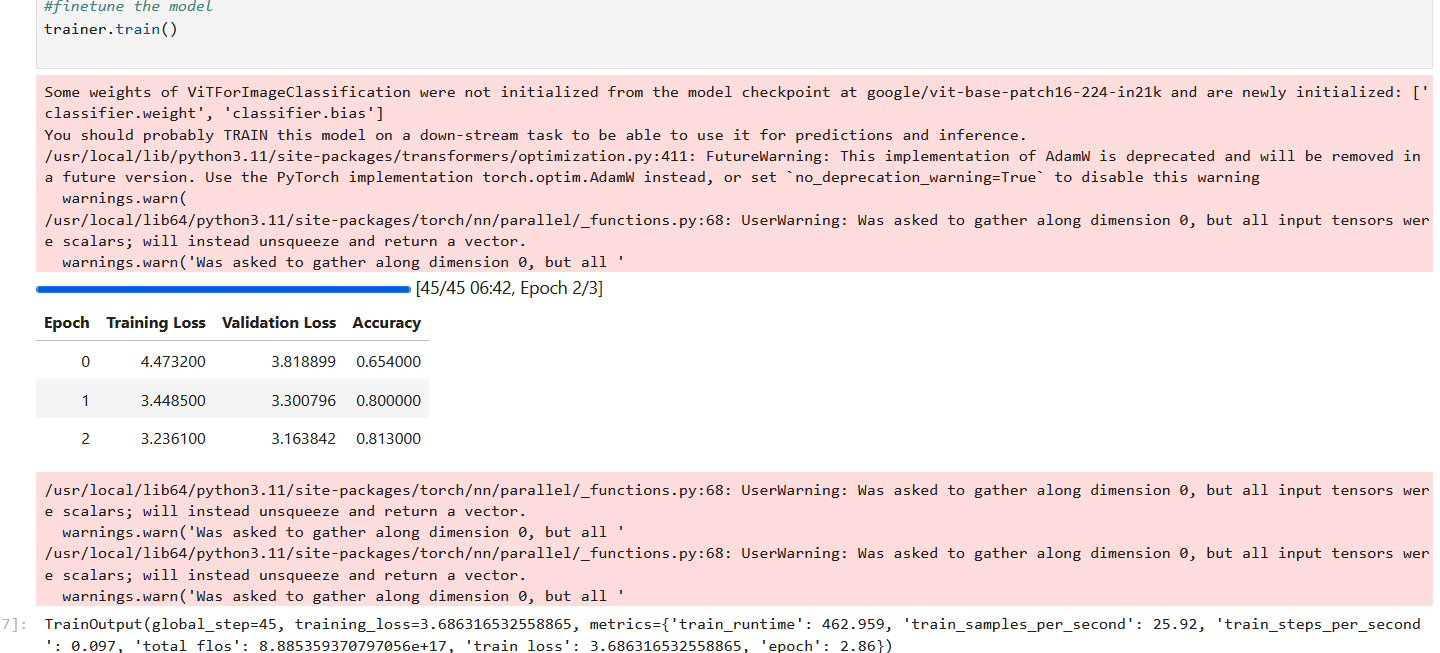

In [ ]:
pip install tensorflow

In [ ]:
pip install nvidia-pyindex

In [ ]:
pip install nvidia-cudnn

In [ ]:
#Fine-tune
#defines the hyperparameters, optimizer and learning rate schedule
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
num_train_steps = len(food["train"]) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

#loads ViT with TFAutoModelForImageClassification along with the label mappings
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

#converts your datasets to the tf.data.Dataset
# converting our train dataset to tf.data.Dataset
tf_train_dataset = food["train"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = food["test"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

#configures the model for training
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

#computes the accuracy from the predictions
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_eval_dataset)

#trains the model
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs, callbacks=metric_callback)

In [ ]:
#Inference
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ds = load_dataset("food101", split="validation[:10]")

image = ds["image"][0]
plt.imshow(image)
plt.show()

#instantiate a pipeline for image classification with your model
from transformers import pipeline

classifier = pipeline("image-classification", model="my_awesome_food_model/checkpoint-45")
classifier(image)


it worked:
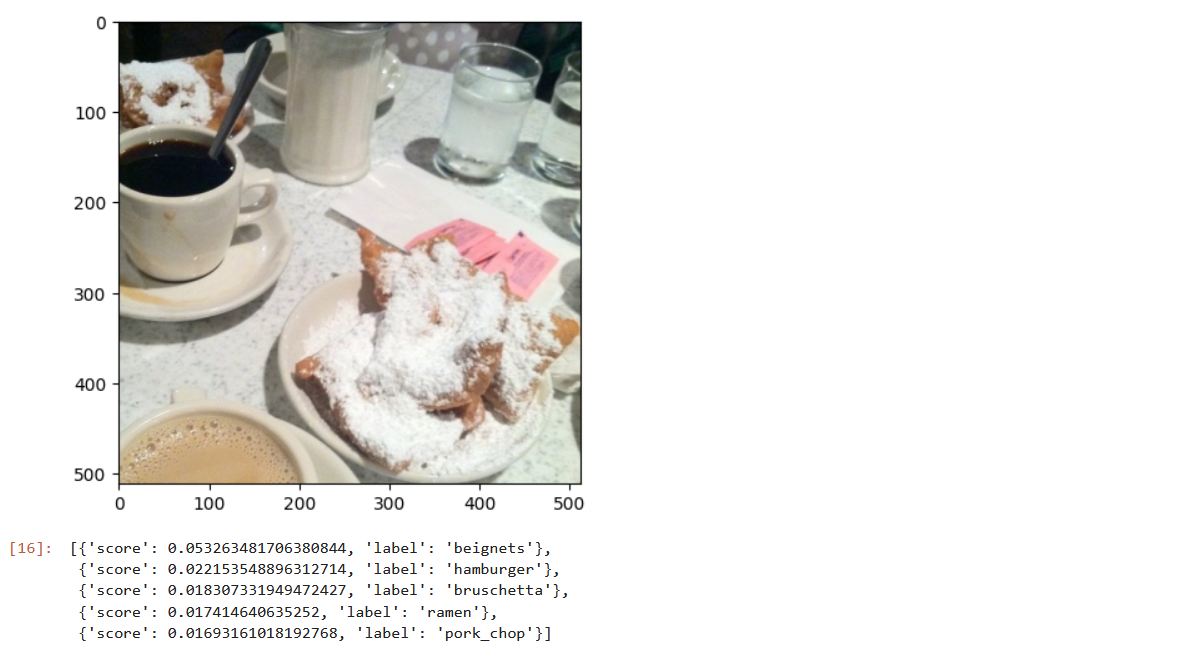

In [ ]:
from transformers import AutoImageProcessor

import torch
ds = load_dataset("food101", split="validation[:10]")

image = ds["image"][0]
plt.imshow(image)
plt.show()
image_processor = AutoImageProcessor.from_pretrained("my_awesome_food_model/checkpoint-45")

inputs = image_processor(image, return_tensors="pt")

from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_awesome_food_model/checkpoint-45")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

it worked:
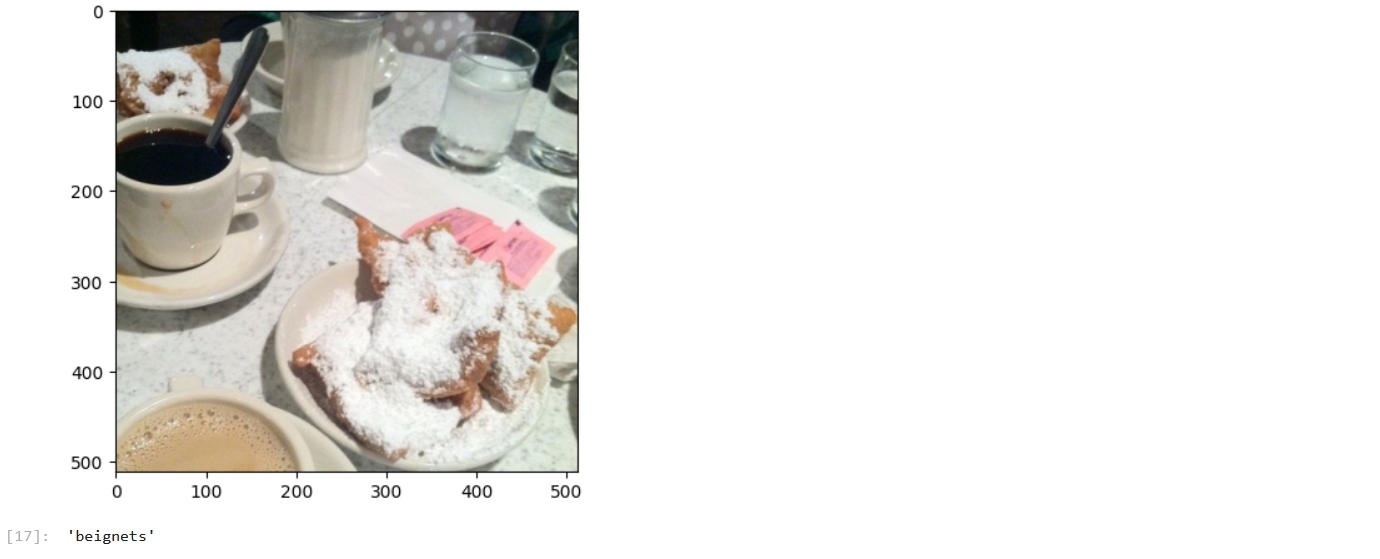

## Part 2 – Using the COCO dataset (8 points)

The HuggingFace tutorial uses one of the datasets in its datasets package. We would like it to be able to be used with the data that we were using in our demo notebook.

Create/modify your own dataloader so that we can use the ViT model to differentiate the cats and horses found in the COCO dataset (i.e. the one from the demo notebook).

In [ ]:
pip install pycocotools

In [ ]:
from pycocotools.coco import COCO
from bs4 import BeautifulSoup
from PIL import Image
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
import torch
from torch.utils.data import Dataset, DataLoader
import random
import pandas as pd
from transformers import DefaultDataCollator
from transformers import AutoImageProcessor
checkpoint = "google/vit-base-patch16-224-in21k"


coco = COCO(annotation_file="/scratch/lt2316-h18-resources/coco/annotations/instances_train2017.json")

datadir="/scratch/lt2316-h18-resources/coco/train2017"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

class CocoHCDataset(Dataset):
    def __init__(self, opt):
        self.path = datadir
        self.imagefiles = opt['file_name']
        self.nSamples = len(self.imagefiles)
        size = (
            image_processor.size["shortest_edge"]
            if "shortest_edge" in image_processor.size
            else (image_processor.size["height"], image_processor.size["width"])
        )
       	transform_list =  [RandomResizedCrop(size),
                           ToTensor(),
                           Normalize(mean=image_processor.image_mean, std=image_processor.image_std)]
        self.transform = Compose(transform_list)
        #self.collate_fn = CocoCollator()
        self.label = opt['class']

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        #assert index <= len(self), 'index range error'
        imagefile = "{}/{}".format(self.path, self.imagefiles[index])
        print(imagefile)
        img = Image.open(imagefile)
        img = _transforms(img.convert("RGB"))
        label = self.label[index]
        item = {'label': label, 'img':img}
        return item

data_collator = DefaultDataCollator()

cat_cat = coco.getCatIds(catNms="cat")
horse_cat = coco.getCatIds(catNms="horse")
cat_imgs = coco.getImgIds(catIds=cat_cat)
horse_imgs = coco.getImgIds(catIds=horse_cat)

#shuffle
random.shuffle(cat_imgs)
cat_imgs_train = cat_imgs[:2000]
cat_imgs_test = cat_imgs[2000:2500]

random.shuffle(horse_imgs)
horse_imgs_train = horse_imgs[:2000]
horse_imgs_test = horse_imgs[2000:2500]

cat_meta_train = coco.loadImgs(ids=cat_imgs_train)
cat_meta_test = coco.loadImgs(ids=cat_imgs_test)
horse_meta_train = coco.loadImgs(ids=horse_imgs_train)
horse_meta_test = coco.loadImgs(ids=horse_imgs_test)


cat_data_train_df = pd.DataFrame(cat_meta_train)
cat_data_train_df['class'] = 'cat'

horse_data_train_df = pd.DataFrame(horse_meta_train)
horse_data_train_df['class'] = 'horse'

cat_data_test_df = pd.DataFrame(cat_meta_test)
cat_data_test_df['class'] = 'cat'

horse_data_test_df = pd.DataFrame(horse_meta_test)
horse_data_test_df['class'] = 'horse'

train_df = pd.concat([cat_data_train_df, horse_data_train_df])
test_df = pd.concat([cat_data_test_df, horse_data_test_df])
print(train_df.head())

def filter_doubles(df):
    vc = df.file_name.value_counts()
    doubles = list(vc[vc>1].index)
    droprows = df[df['file_name'].isin(doubles)]
    return df.drop(droprows.index)

train_df = filter_doubles(train_df)
train_df = train_df[['file_name', 'class']]
test_df = filter_doubles(test_df)
test_df = test_df[['file_name', 'class']]

CH_data_train = CocoHCDataset(train_df)
CH_data_test = CocoHCDataset(test_df)

In [ ]:
#Evaluation
import evaluate

accuracy = evaluate.load("accuracy")

#passes your predictions and labels to compute to calculate the accuracy
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
#training

from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

CH_model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=1,
    #id2label={1:"cat", 0:"horse"},
    #label2id={"cat":1, "horse":0},
)

CH_training_args = TrainingArguments(
    output_dir="my_awesome_animals_model",
    remove_unused_columns=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

CH_trainer = Trainer(
    model=CH_model,
    args=CH_training_args,
    data_collator=data_collator,
    train_dataset=CH_data_train,
    eval_dataset=CH_data_test,
    #tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

CH_trainer.train()

## Part 3 – Multiclass Classification (8 points)

The original task was only with binary classification. Get it to do multiclass classification, preferably on similar kinds of targets (like the cats and horses example, as opposed to cats and airplanes). You can find a list of categories for the dataset [here](https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/).

Do this both for the original CNN model and for the ViT model.

## Part 4 – How does the classification work now? (7 points)

Do a comparison of the models, both quantitative and qualitative. How does the models’ performances vary from each other? Is one of the models better at specific things than the other? Or is one of them much better than the other? Moreover, are these differences the same between both the binary classification task and in a multiclass classification task?